In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [88]:
# Load and prepare general dataset
df = pd.read_csv('/kaggle/input/startup-failures/Startup Failures.csv')
df = df.convert_dtypes()
df['Duration'] = df['Years of Operation'].str.extract(r'(\d+)').astype(int)
df['Start Year'] = df['Years of Operation'].str.extract(r'\((\d{4})-').fillna(0).astype(int)
df['End Year'] = df['Years of Operation'].str.extract(r'-(\d{4})\)').fillna(0).astype(int)

In [89]:
# Load sector-specific datasets
df_finance = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Finance and Insurance).csv')
df_food = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Food and services).csv')
df_health = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Health Care).csv')
df_manufactures = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Manufactures).csv')
df_retail = pd.read_csv('/kaggle/input/startup-failures/Startup Failure (Retail Trade).csv')
df_information = pd.read_csv('/kaggle/input/startup-failures/Startup Failures (Information Sector).csv')
sector_dfs = [df_finance, df_food, df_health, df_manufactures, df_retail, df_information]
for df_sector in sector_dfs:
    df_sector = df_sector.convert_dtypes()

In [90]:
df_finance.head()

,Name,Sector,Years of Operation,What They Did,How Much They Raised,Why They Failed,Takeaway,Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,Platform Dependency,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts,Toxicity/Trust Issues,Regulatory Pressure,Overhype
0,Avant,Finance and Insurance,2012-2023,Online personal loans,$655M,Lost to LendingClub and high defaults,Lending needs risk balance,1,1,1,0,0,0,0,0,0,0,0,0,0.0
1,Bitpass,Finance and Insurance,2002-2008,Micropayments platform,$2M,Lost to PayPal and low adoption,Micropayments need mass use,1,0,1,1,0,0,0,0,0,0,0,0,0.0
2,Cake Financial,Finance and Insurance,2006-2011,Portfolio tracking tool,$3M,Lost to Mint and sold to TradeKing,Finance tools need scale,1,0,1,0,1,0,0,0,0,0,0,0,0.0
3,Circle,Finance and Insurance,2013-2023,Crypto payments and stablecoin,$500M,Lost to Coinbase and market shifts,Crypto needs stability,1,0,1,0,0,0,0,0,0,1,0,0,0.0
4,Clarity Money,Finance and Insurance,2016-2022,Personal finance app,$11M,Lost to Mint/Acorns and sold to Goldman,Finance apps need edge,1,0,1,0,1,0,0,0,0,0,0,0,0.0


In [91]:
df_food.head()

,Name,Sector,Years of Operation,What They Did,How Much They Raised,Why They Failed,Takeaway,Giants,No Budget,Competition,Poor Market Fit,Acquisition Stagnation,High Operational Costs,Monetization Failure,Niche Limits,Execution Flaws,Trend Shifts
0,Cafe X,Accommodation and Food Services,6 (2015-2021),Robotic coffee kiosks,$15M,Closed 2021; low adoption; lost to Starbucks,Humans trump robots,1,0,1,1,0,1,0,0,0,0
1,Caviar,Accommodation and Food Services,8 (2012-2020),Premium food delivery,$90M,Sold 2020; couldn't scale; lost to DoorDash,Premium loses to scale,1,0,1,0,1,0,0,0,0,0
2,Chef'd,Accommodation and Food Services,5 (2014-2019),Meal kit delivery,$35M,Closed 2019; high costs; lost to Blue Apron,Costs cook meal kits,1,0,1,0,0,1,0,0,0,0
3,ChowNow,Accommodation and Food Services,12 (2011-2023),Restaurant ordering platform,$64M,Faded 2023; lost to DoorDash,Middlemen get squeezed,1,0,1,0,0,0,0,0,0,0
4,Clover,Accommodation and Food Services,8 (2012-2020),Plant-based fast food chain,$20M,Closed 2020; niche; lost to McDonald's,Niche eats need taste,1,0,1,0,0,1,0,1,0,0


In [92]:
# Functions
def clean_funding(x):
    if pd.isna(x) or 'Unknown' in str(x):
        return 0
    numeric_part = re.match(r'^\s*\$?(\d*\.?\d+)', str(x).replace('$', ''))
    if numeric_part:
        value = numeric_part.group(1)
        if 'M' in str(x).upper():
            return float(value) * 1e6
        elif 'K' in str(x).upper():
            return float(value) * 1e3
        else:
            return float(value)
    return 0

def extract_duration(x):
    if pd.isna(x):
        return 0
    # Try 'YYYY-YYYY' format first
    if '-' in x and '(' not in x:
        try:
            start_year, end_year = map(int, x.split('-'))
            return end_year - start_year
        except (ValueError, AttributeError):
            return 0
    # Then try 'X (YYYY-YYYY)' format
    match = re.search(r'(\d+)\s*\((\d{4})-(\d{4})\)', str(x))
    if match:
        return int(match.group(1))  # Use the pre-calculated duration
    # Fallback: Extract years and calculate
    years_match = re.search(r'(\d{4})-(\d{4})', str(x))
    if years_match:
        return int(years_match.group(2)) - int(years_match.group(1))
    return 0

In [93]:
# Prepare datasets
for df_sector in sector_dfs:
    df_sector['Duration'] = df_sector['Years of Operation'].apply(extract_duration)
    df_sector['Funding ($M)'] = df_sector['How Much They Raised'].apply(clean_funding) / 1e6

df['Funding ($M)'] = pd.NA
df['What They Did'] = pd.NA
df['How Much They Raised'] = pd.NA
df['Why They Failed'] = pd.NA
df['Takeaway'] = pd.NA

common_columns = ['Name', 'Sector', 'Years of Operation', 'Duration', 
                  'What They Did', 'How Much They Raised', 'Funding ($M)', 
                  'Why They Failed', 'Takeaway']

failure_reasons = set()
for df_sector in sector_dfs:
    failure_reasons.update([col for col in df_sector.columns if col not in common_columns])
failure_reasons = list(failure_reasons)

for reason in failure_reasons:
    if reason not in df.columns:
        df[reason] = 0

In [94]:
# Merge
all_dfs = [df] + sector_dfs
merged_df = pd.concat(all_dfs, axis=0, ignore_index=True, join='outer')
merged_df = merged_df.convert_dtypes()

<ipython-input-94-0e64435bec40>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(all_dfs, axis=0, ignore_index=True, join='outer')


In [95]:
# Fill missing values
filled_df = merged_df.copy()
filled_df['Funding ($M)'] = filled_df['Funding ($M)'].fillna(0)
filled_df['How Much They Raised'] = filled_df['How Much They Raised'].fillna('Unknown')
filled_df['What They Did'] = filled_df['What They Did'].fillna('Not Available')
filled_df['Why They Failed'] = filled_df['Why They Failed'].fillna('Not Available')
filled_df['Takeaway'] = filled_df['Takeaway'].fillna('Not Available')
filled_df['Start Year'] = filled_df['Start Year'].fillna(0).astype(int)
filled_df['End Year'] = filled_df['End Year'].fillna(0).astype(int)

for col in failure_reasons:
    filled_df[col] = filled_df[col].fillna(0).astype(int)

In [96]:
# Verify
print("Merged Info:", merged_df.info())
print("Filled Info:", filled_df.info())
print("Missing Values:", filled_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1224 non-null   string 
 1   Sector                  1224 non-null   string 
 2   Years of Operation      1224 non-null   string 
 3   Duration                1224 non-null   Int64  
 4   Start Year              815 non-null    Int64  
 5   End Year                815 non-null    Int64  
 6   Funding ($M)            409 non-null    Float64
 7   What They Did           409 non-null    string 
 8   How Much They Raised    409 non-null    string 
 9   Why They Failed         409 non-null    string 
 10  Takeaway                409 non-null    string 
 11  Regulatory Pressure     1198 non-null   Int64  
 12  Execution Flaws         1224 non-null   Int64  
 13  Platform Dependency     1198 non-null   Int64  
 14  Toxicity/Trust Issues   1198 non-null   

In [97]:
filled_df.head()

,Name,Sector,Years of Operation,Duration,Start Year,End Year,Funding ($M),What They Did,How Much They Raised,Why They Failed,...,High Operational Costs,Overhype,Competition,Poor Market Fit,No Budget,Acquisition Stagnation,Trend Shifts,Monetization Failure,Giants,Niche Limits
0,99dresses,Retail Trade,3 (2010-2013),3,2010,2013,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
1,Ahalife,Retail Trade,7 (2010-2017),7,2010,2017,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
2,Airy Labs,Information,2 (2010-2012),2,2010,2012,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
3,AllRomance,Retail Trade,10 (2006-2016),10,2006,2016,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0
4,Ampush,Professional Scientific and Technical Services,13 (2010-2023),13,2010,2023,0.0,Not Available,Unknown,Not Available,...,0,0,0,0,0,0,0,0,0,0


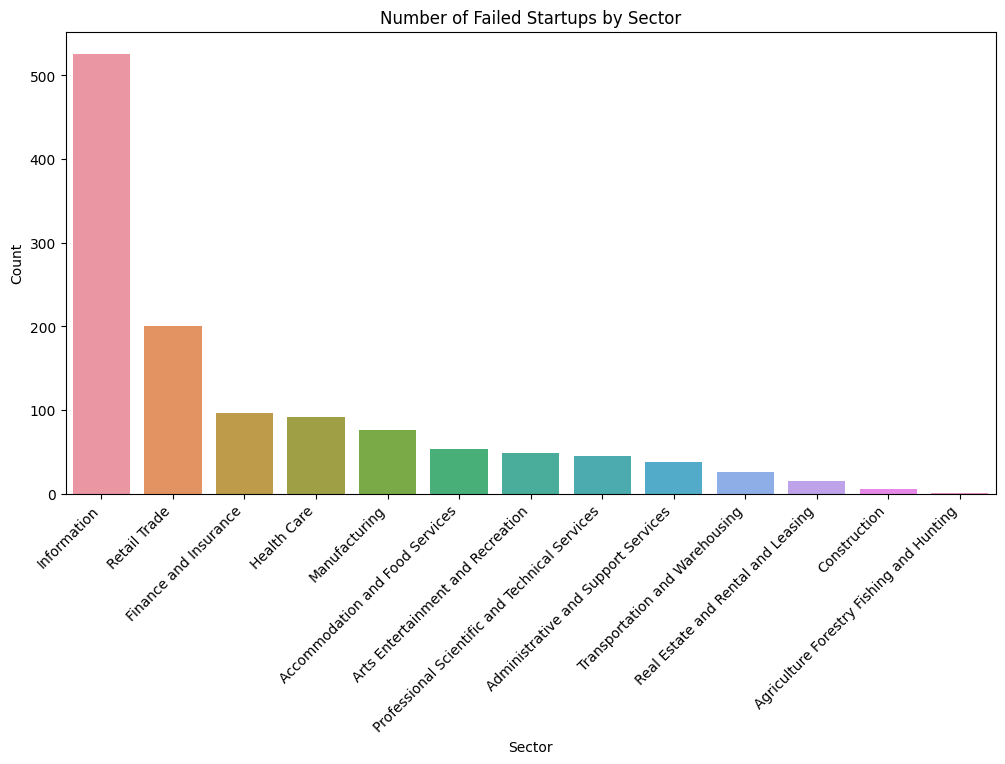

Top 5 Sectors by Failure Count:
 Sector
Information              526
Retail Trade             200
Finance and Insurance     97
Health Care               92
Manufacturing             76
Name: count, dtype: Int64


In [98]:
# Sector counts
sector_counts = filled_df['Sector'].value_counts()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Failed Startups by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.show()

print("Top 5 Sectors by Failure Count:\n", sector_counts.head())

Duration Statistics:
 count      1224.0
mean     7.588235
std      3.386336
min           0.0
25%           5.0
50%           7.0
75%          10.0
max          18.0
Name: Duration, dtype: Float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


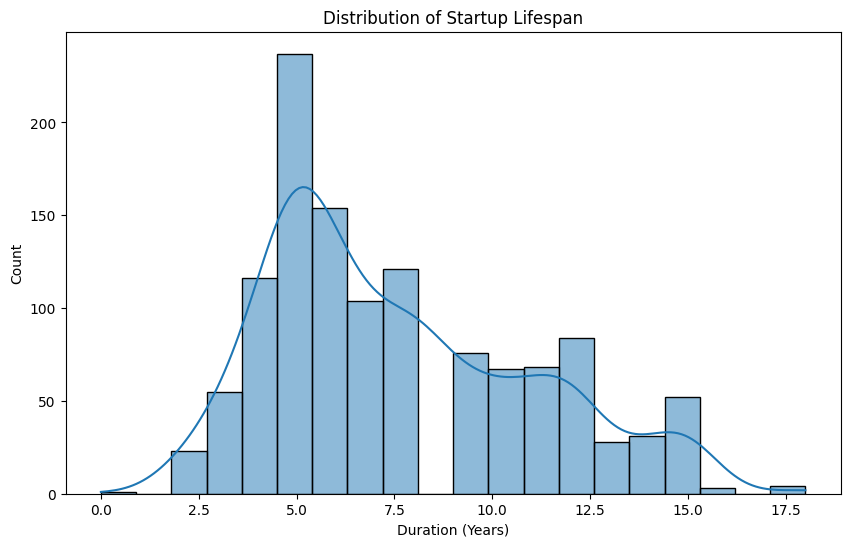

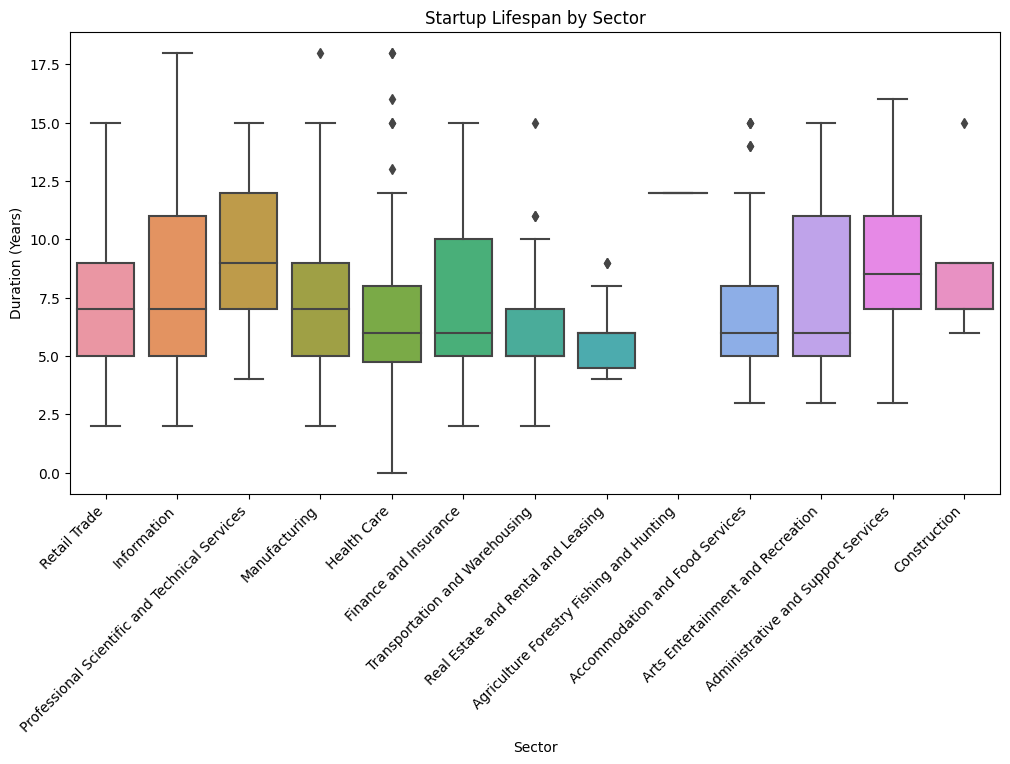

In [99]:
# Summary statistics
print("Duration Statistics:\n", filled_df['Duration'].describe())

# Histogram of Duration
plt.figure(figsize=(10, 6))
sns.histplot(filled_df['Duration'], bins=20, kde=True)
plt.title('Distribution of Startup Lifespan')
plt.xlabel('Duration (Years)')
plt.ylabel('Count')
plt.show()

# Boxplot by Sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sector', y='Duration', data=filled_df)
plt.xticks(rotation=45, ha='right')
plt.title('Startup Lifespan by Sector')
plt.xlabel('Sector')
plt.ylabel('Duration (Years)')
plt.show()

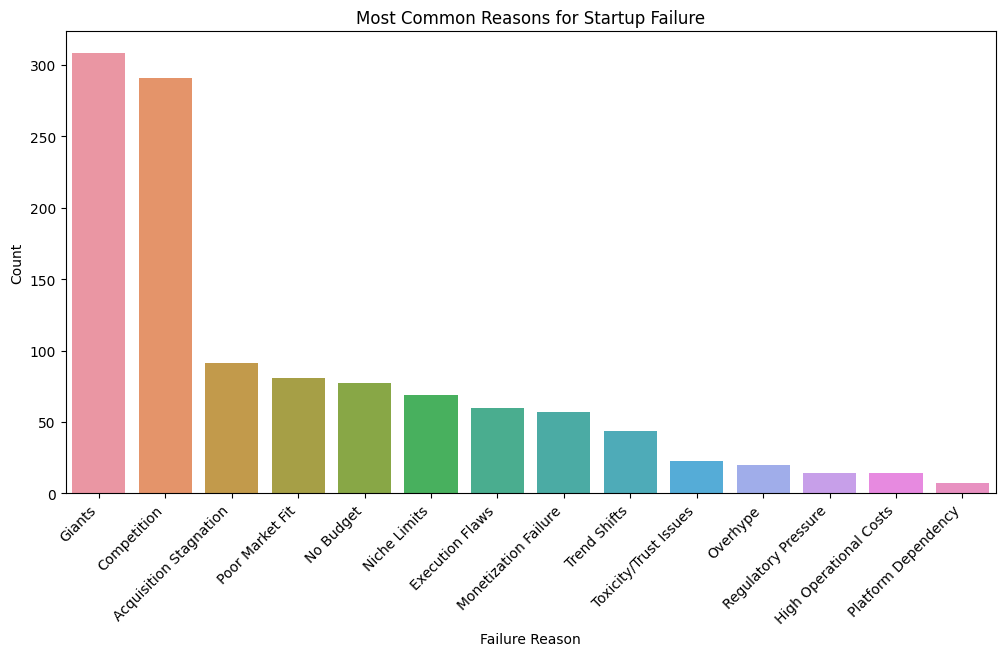

Top Failure Reasons:
 Giants                    308
Competition               291
Acquisition Stagnation     91
Poor Market Fit            81
No Budget                  77
dtype: int64


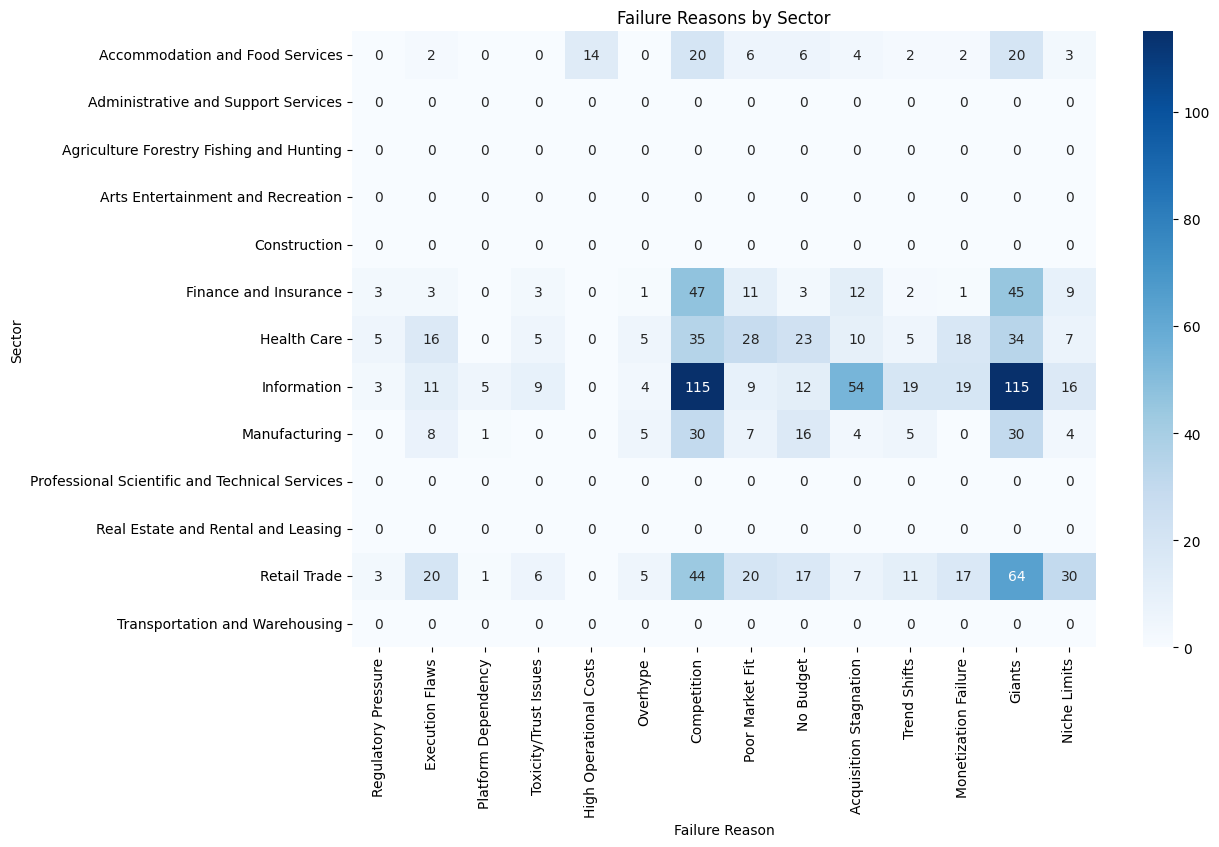

In [100]:
# Sum failure reasons
failure_reasons = [col for col in filled_df.columns if col not in 
                   ['Name', 'Sector', 'Years of Operation', 'Duration', 'Start Year', 'End Year',
                    'What They Did', 'How Much They Raised', 'Funding ($M)', 'Why They Failed', 'Takeaway']]
failure_counts = filled_df[failure_reasons].sum().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=failure_counts.index, y=failure_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Reasons for Startup Failure')
plt.xlabel('Failure Reason')
plt.ylabel('Count')
plt.show()

print("Top Failure Reasons:\n", failure_counts.head())

# Heatmap by Sector
failure_by_sector = filled_df.groupby('Sector')[failure_reasons].sum()
plt.figure(figsize=(12, 8))
sns.heatmap(failure_by_sector, annot=True, cmap='Blues', fmt='d')
plt.title('Failure Reasons by Sector')
plt.xlabel('Failure Reason')
plt.ylabel('Sector')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


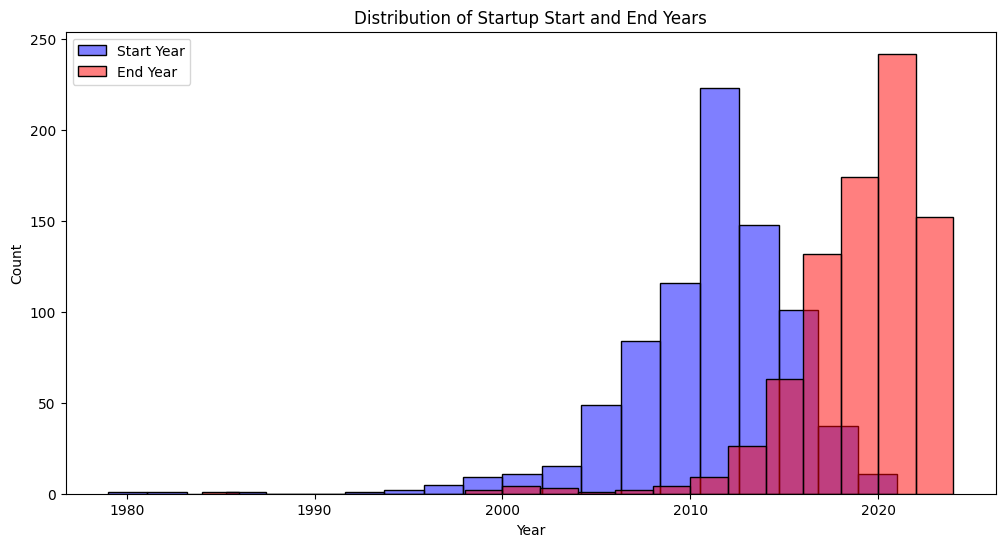

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


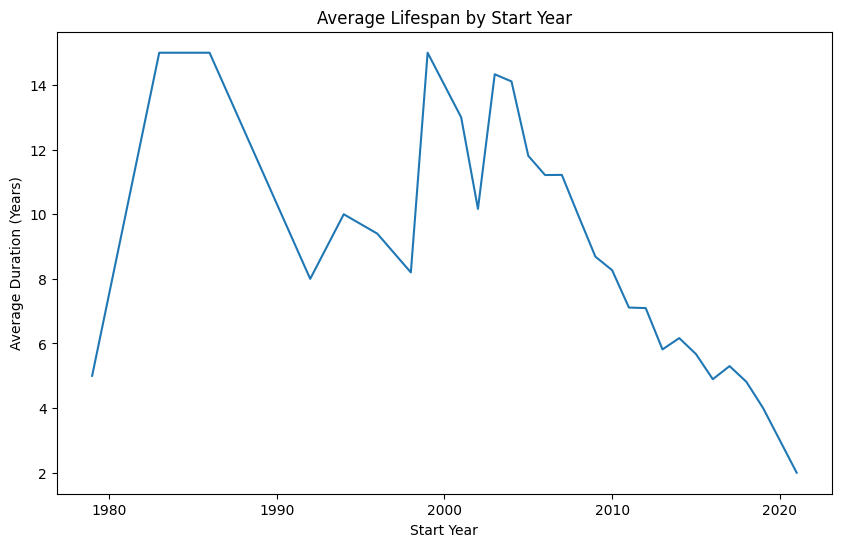

In [101]:
# Filter out imputed zeros for meaningful trends
non_zero_years = filled_df[(filled_df['Start Year'] > 0) & (filled_df['End Year'] > 0)]

# Histogram of Start and End Years
plt.figure(figsize=(12, 6))
sns.histplot(non_zero_years['Start Year'], bins=20, color='blue', label='Start Year', alpha=0.5)
sns.histplot(non_zero_years['End Year'], bins=20, color='red', label='End Year', alpha=0.5)
plt.legend()
plt.title('Distribution of Startup Start and End Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Average duration by Start Year
duration_by_start = non_zero_years.groupby('Start Year')['Duration'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=duration_by_start.index, y=duration_by_start.values)
plt.title('Average Lifespan by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Average Duration (Years)')
plt.show()